# Error Analyses

Please see here the plot / data as I believe they should be, and my aimed replicate of the previous plots at the bottom of this notebook

In [5]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import quail
import pickle
import scipy
import scipy.stats
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from itertools import groupby
from collections import OrderedDict

%matplotlib inline

# Load Data

In [6]:
man = quail.load_egg('../data/man_egg.egg')
auto = quail.load_egg('../data/auto_egg.egg')

In [7]:
man_errs = {'external': [], 'intrusion': [], 'num recalled': [], 'sep_rec': []}
auto_errs = {'external': [], 'intrusion': [], 'num recalled': [], 'sep_rec': []}

for trans,dic in zip([man,auto], [man_errs, auto_errs]): 
    for sub in range(len(auto.meta['ids'])):
    
        all_presented = []
        external = []
        intrusion = [0]*8
        num_recalled = []
        
        for lst in range(0,8):
            ext_count = 0
            
            # load pres and rec
            recalled = [x for x in trans.rec.loc[sub].loc[lst].values if type(x)==str] 
            presented = trans.pres.loc[sub].loc[lst].values
            num_recalled.append(len(recalled))
            
            # select recalls not from this pres 
            extras = [x for x in recalled if x not in presented]
            
            # if extra word prev presented, add to intrusion 
            for word in extras:
                intr = 0
                
                for idx,sublist in enumerate(all_presented):
                    if word in sublist:
                        intrusion[lst-idx]+=1.0
                        intr += 1
                
                if intr == 0:
                    ext_count+=1
       
            # append prop recalls that are external errors
            external.append(ext_count/float(len(recalled)))
            all_presented.append(presented)
        
        dic['external'].append(np.mean(external))
        dic['intrusion'].append(intrusion)  
        dic['num recalled'].append(sum(num_recalled))
        dic['sep_rec'].append(num_recalled)

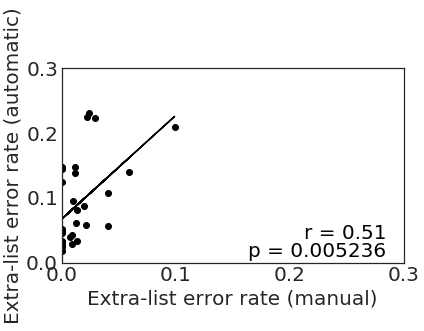

In [9]:
#plot average proportion of external errors in man vs. auto transcription on scatter plot
sns.set_style('white')
fig, ax = plt.subplots()
plt.scatter(man_errs['external'], auto_errs['external'], color = 'black', edgecolors = 'black')

#label axes
ax.set_xlabel('Extra-list error rate (manual)', size = 20)
ax.set_ylabel('Extra-list error rate (automatic)', size = 20)
plt.tick_params(labelsize=20)
plt.xlim(0, .3)
plt.ylim(0, .3)

#get line of best fit
reg_line = np.polyfit(man_errs['external'], auto_errs['external'], 1)
reg_line_fn = np.poly1d(reg_line)
plt.plot(man_errs['external'], reg_line_fn(man_errs['external']), color = 'black')

#get R value
r = pearsonr(man_errs['external'], auto_errs['external'])
r_plot = str(r[0])
p_plot=str(r[1])
#print r
ax.text(.95, .2, 'r = '+r_plot[0:4], horizontalalignment='right', verticalalignment='top',
transform=ax.transAxes, color='black', fontsize=20)
ax.text(0.95, 0.03, 'p = '+p_plot[0:4]+p_plot[-4:], horizontalalignment='right',
transform=ax.transAxes, color='black', fontsize=20)

#save plot and show
plt.tight_layout()
plt.style.use('default')
fig.savefig('XLI_KZ.pdf')
plt.show()

In [ ]:
for error in [man_errs, auto_errs]:
    for index,subj in enumerate(error['intrusion']):
        for idx,num in enumerate(subj):
            
            if num != 0 and num != 0.0:

                # take each raw value and divide by total recalled words and number of possible list back errors
                subj[idx] = num / (error['num recalled'][index] * 16.0 * idx)


# Create Plot

In [ ]:
sns.set_style('white')

#set up the grid
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.tight_layout(pad=2, w_pad=1.5, h_pad=1.5)


#plot prior list errors for each list back
man_means = []
auto_means = []

man_full = []
auto_full = []

for i in range(1, 6):
    
    ax = axs.flat[i]
    
    man_plot = [x[i] for x in man_errs['intrusion']]
    auto_plot = [x[i] for x in auto_errs['intrusion']]
    
    man_full.append(man_plot)
    auto_full.append(auto_plot)

    ax.scatter (man_plot, auto_plot, color = 'black', edgecolors = 'black')  
    
    #get R value
    r = pearsonr(man_plot, auto_plot)
    r_plot = str(r[0])
    p_plot = str(r[1])
    
    #get line of best fit
    reg_line = np.polyfit(man_plot, auto_plot, 1)
    reg_line_fn = np.poly1d(reg_line)
    ax.set_title(str(i)+' list back', size = 9)
    ax.set_xlim(0, 0.003)
    ax.set_ylim(0, 0.003)
    ax.plot(man_plot, reg_line_fn(man_plot), color = 'black')
    
    ax.text(0.95, 0.03, 'p = '+p_plot[0:4]+p_plot[-4:], horizontalalignment='right',
    transform=ax.transAxes, color='black', fontsize=10)
    ax.text(.95, .2, 'r = '+r_plot[0:4], horizontalalignment='right', verticalalignment='top',
    transform=ax.transAxes, color='black', fontsize=10)
    
    man_means.append(np.mean(man_plot))
    auto_means.append(np.mean(auto_plot))
    
#     print('correlation for '+str(i)+' lists back: ')
#     print r
#     print(' ')

x = np.array(man_full)
y = np.array(auto_full)
sns.tsplot(np.transpose(x), ax=axs.flat[0], color = 'blue')
sns.tsplot(np.transpose(y), ax=axs.flat[0], color = 'green')
axs.flat[0].set_ylim(0,.00042)

#legend
ax.legend(loc = 'upper right', fontsize = 'x-small')
fig.savefig('updated.pdf')





# Replicate Mistake

In [263]:
mans = []
autos = []
for typ in [man_errs,auto_errs]:
    for x,y in zip(typ['intrusion'],typ['sep_rec']):
        if typ == man_errs:
            mans.append([a/b for a,b in zip(x,y)])
        else:
            autos.append([a/b for a,b in zip(x,y)])

In [264]:
for typ in [mans,autos]:
    for index,lst in enumerate(typ):
        for idx,x in enumerate(lst):
            if idx!=0:
                typ[index][idx] = x/(idx*16)

(0.9506534379088233, 9.184401321791529e-16)
(0.8543287889126205, 1.9032395443905375e-09)
(0.9917232543537262, 1.6485110153633218e-26)
(nan, 1.0)
(0.839044797992095, 6.96564180369715e-09)


AttributeError: 'AxesSubplot' object has no attribute 'flat'

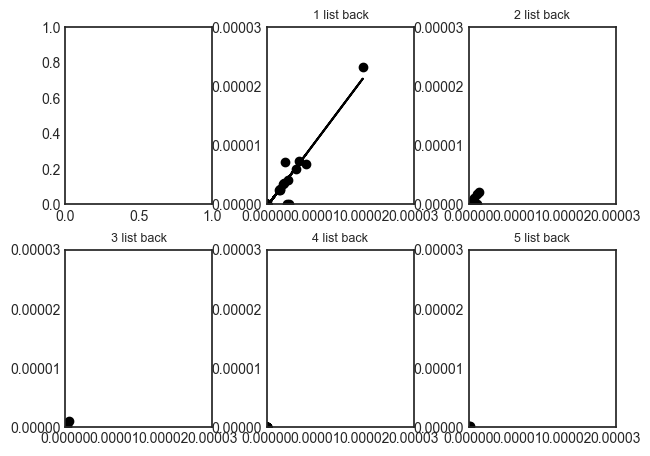

In [265]:
sns.set_style('white')

#set up the grid
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.tight_layout(pad=2, w_pad=1.5, h_pad=1.5)


#plot prior list errors for each list back
man_means = []
auto_means = []

man_full = []
auto_full = []

for i in range(1, 6):
    
    ax = axs.flat[i]
    
    man_plot = [x[i] for x in mans]
    auto_plot = [x[i] for x in autos]
    
    man_full.append(man_plot)
    auto_full.append(auto_plot)

    #print(man_plot)
    #scatter plot
    ax.scatter (man_plot, auto_plot, color = 'black', edgecolors = 'black')  
    
    #get line of best fit
    reg_line = np.polyfit(man_plot, auto_plot, 1)
    reg_line_fn = np.poly1d(reg_line)
    ax.set_title(str(i)+' list back', size = 9)
    ax.set_xlim(0, 0.00003)
    ax.set_ylim(0, 0.00003)
    ax.plot(man_plot, reg_line_fn(man_plot), color = 'black')
    
    #get R value
    r = pearsonr(man_plot, auto_plot)
    #ax.text(str(r), size = 8)
    #ax.text(0.015, 0.0025, '$p<0.001$', size = 8)
    #print(np.mean(man_plot))
    man_means.append(np.mean(man_plot))
    auto_means.append(np.mean(auto_plot))
    
    if i == 6:
        print(man_plot)
        print(auto_plot)
    
    print r


#plot p(error) by list back
ax = ax.flat[0]
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_ylim(0, 0.00042)
# sns.tsplot(np.array(man_plot))


#ax.scatter(range(1,6), man_means, color = 'blue', label = 'manual')
#ax.scatter(range(1,6), auto_means, color = 'green', label = 'automatic')


#set axes labels
ax.set_xlabel('Number of lists back', size = 7)
# ax.set_ylabel('Average intrusion error rate (x$10^{-3}$)', size = 7)


#legend
ax.legend(loc = 'upper right', fontsize = 'x-small')
  
plt.show()